# Project 2: Finding Fraud

## Load Libraries

In [69]:
import pandas as pd
import zipfile

#-----------------------

import warnings
warnings.filterwarnings('ignore')

# -- pandas and numpy --
import numpy as np
import pandas as pd

# -- plotting --
import matplotlib.pyplot as plt
import seaborn as sns

# -- sklearn --

# -- sklearn modules
from sklearn.model_selection import train_test_split   #- partition train/test split
from sklearn.ensemble import RandomForestClassifier    #- random forest classifier
from sklearn.ensemble import GradientBoostingClassifier #- gradient boosting classifier
from sklearn.tree import DecisionTreeClassifier         #- decision tree classifier

# -- we need these to make our pipelines
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV # NOTE...
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

# -- we need these to evaluate our models
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# -- need this to render charts in notebook --
%matplotlib inline

## Import Data/Open Zips

In [51]:
url = 'https://raw.githubusercontent.com/MikeVej/MachineLearning_FraudDetection/Model-Code/Data_CSV/project_2_training.csv'
df_train = pd.read_csv(url)

df_train.head()

,EVENT_ID,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,2608000,5774.00000,2172.00000,78.00000,4523.00000,81.237.240.91,Mozilla/5.0 (iPod; U; CPU iPhone OS 3_0 like M...,graves.org,456-910-9478,South Angelaville,...,R,2021-02-21 16:32:23,Kristi Bell,7683 Chavez Curve,882-35-3409,es_VE,Q,82.00000,4609.00000,legit
1,214500,5405.00000,2887.00000,51.00000,4057.00000,160.32.216.178,Mozilla/5.0 (Macintosh; PPC Mac OS X 10 10_7) ...,howard-madden.com,269.363.8079,Lake Leslietown,...,O,2020-12-30 11:36:17,Amanda Bond,628 Cline Streets,453-93-1357,bhb_IN,S,2.00000,12384.00000,legit
2,294600,6570.00000,2887.00000,56.00000,5602.00000,109.156.235.28,Mozilla/5.0 (Windows NT 6.2) AppleWebKit/535.2...,walsh-goodwin.com,366.185.9975,Lake Kendra,...,C,2021-03-24 05:34:28,Joanna Walton,268 Ashley Plaza Apt. 416,554-51-8940,mi_NZ,W,43.00000,9607.00000,legit
3,477060,3865.00000,1591.00000,58.00000,3926.00000,158.152.249.45,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,gonzalez-diaz.com,816-365-8213,East Maryport,...,G,2021-10-12 16:24:49,Matthew Johnson,8377 Jacob Course,492-66-7677,yue_HK,Y,71.00000,10305.00000,legit
4,1993100,6625.00000,3297.00000,70.00000,6675.00000,167.164.91.31,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,bender-rocha.info,001-970-935-1735x19620,Yorkburgh,...,W,2021-06-23 00:05:15,Susan Phillips,401 Christopher Meadows,468-86-6030,gd_GB,Q,52.00000,4139.00000,legit


In [39]:
url1 = 'https://raw.githubusercontent.com/MikeVej/MachineLearning_FraudDetection/Model-Code/Data_CSV/project_2_holdout.csv'
# Load the dataset
df_holdout = pd.read_csv(url1)

# Display the first few rows of the dataframe
df_holdout.head()

,EVENT_ID,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,...,transaction_type,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount
0,109420,4462,3648,54,6325,197.108.209.59,Opera/8.29.(X11; Linux i686; mk-MK) Presto/2.9...,perez-smith.org,+1-776-557-7526x274,Danielville,...,D,G,3/28/21 22:17,Mrs. Dawn Murray,414 Gregory Mountains Suite 443,618-52-2474,gd_GB,O,23.00000,2422.00000
1,1049060,3360,2180,54,4030,178.166.190.20,Opera/8.16.(X11; Linux i686; is-IS) Presto/2.9...,morris-diaz.com,001-427-310-1481x093,Thompsonshire,...,D,F,5/29/21 6:26,William Hughes,67405 Higgins Ways,651-14-8114,iu_CA,U,58.00000,2160.00000
2,2805320,4725,2063,60,4372,163.48.86.34,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,campos-brown.net,073.152.2261,North Lisaburgh,...,U,Z,3/17/21 7:35,Jennifer Johnson,41514 Toni Junction Suite 866,824-13-0148,yue_HK,O,34.00000,14474.00000
3,450840,5336,2319,72,4385,55.233.5.10,Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10 1...,hanna-taylor.com,835-295-8283x42594,Joelville,...,X,W,4/26/21 5:34,Brenda Hopkins,1991 Angela Falls,633-56-8621,sa_IN,Y,84.00000,13297.00000
4,423160,6115,3413,61,5942,119.228.12.223,Opera/8.21.(X11; Linux i686; cv-RU) Presto/2.9...,gregory.com,424.203.8183,Hallburgh,...,D,W,1/17/21 13:25,Patricia Davis,57145 Walton Valleys Suite 250,636-15-1188,doi_IN,I,89.00000,5425.00000


## Exploratory Data Analysis:

### Describe Data (Categorical or Numeric?)

In [52]:
def df_profile(df, target):

    df = df_train.copy()

    numeric_features = [ c for c in df.select_dtypes(include = np.number).columns ]
    pd.options.display.float_format = '{:.5f}'.format

    categorical_features = [ c for c in df.select_dtypes(include = "object").columns ]

    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)
    df_s1['count'] = df_s1['count'].astype('int64')
    df_s1['nunique'] = df_s1['nunique'].astype('int64')
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique'] / rowcnt


    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner')

    df_stats = df_stats.sort_values("dtype").reset_index(drop=True)

    df_stats['feature_type'] = "UNKNOWN"
    df_stats.loc[np.logical_or(df_stats['dtype'] == int, df_stats['dtype'] == float), 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats['dtype'] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[df_stats['feature_name'] == target, 'feature_type'] = "TARGET"

    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[df_stats['nunique_pct'] > 0.9, 'feature_warning'] = "EXCLUDE, GT 90% UNIQUE"
    df_stats.loc[df_stats['null_pct'] > 0.2, 'feature_warning'] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats['null_pct'] > 0.5, 'feature_warning'] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[np.logical_and(np.logical_or(df_stats['dtype'] == int, df_stats['dtype'] == float), df_stats['nunique'] <= 20), 'feature_warning'] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"

    return df_stats

dfp = df_profile(df_train, 'riskperformance')
dfp

,feature_name,dtype,count,nunique,mean,min,max,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
0,EVENT_ID,int64,125000,125000,1500443.74368,20.00000,2999960.00000,0,125000,0.00000,1.00000,UNKNOWN,"EXCLUDE, GT 90% UNIQUE"
1,account_age_days,float64,125000,6363,4642.45354,-1.00000,9119.00000,0,125000,0.00000,0.05090,NUMERIC,NO WARNING
2,transaction_amt,float64,125000,3641,2519.54538,-1.00000,4880.00000,0,125000,0.00000,0.02913,NUMERIC,NO WARNING
3,transaction_adj_amt,float64,125000,93,54.14210,-1.00000,99.00000,0,125000,0.00000,0.00074,NUMERIC,NO WARNING
4,historic_velocity,float64,125000,6633,4699.90033,-1.00000,8875.00000,0,125000,0.00000,0.05306,NUMERIC,NO WARNING
5,days_since_last_logon,float64,124887,101,49.81432,0.00000,100.00000,113,124887,0.00090,0.00081,NUMERIC,NO WARNING
6,billing_postal,float64,124902,11064,50210.79106,503.00000,99950.00000,98,124902,0.00078,0.08851,NUMERIC,NO WARNING
7,card_bin,float64,124890,6321,41813.29049,6040.00000,67639.00000,110,124890,0.00088,0.05057,NUMERIC,NO WARNING
8,inital_amount,float64,124891,13999,7999.64274,1000.00000,15000.00000,109,124891,0.00087,0.11199,NUMERIC,NO WARNING
9,tranaction_initiate,object,124900,26,NaN,NaN,NaN,100,124900,0.00080,0.00021,CATEGORY,NO WARNING


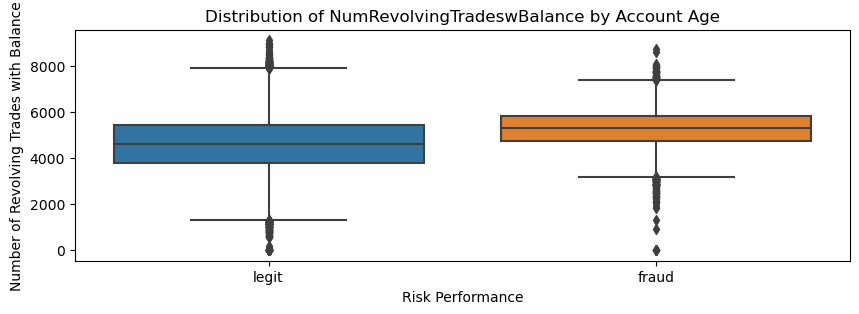

In [53]:
plt.figure(figsize=(10, 3))
sns.boxplot(x='EVENT_LABEL', y='account_age_days', data=df_train)
plt.title('Distribution of NumRevolvingTradeswBalance by Account Age')
plt.xlabel('Risk Performance')
plt.ylabel('Number of Revolving Trades with Balance')
plt.show()

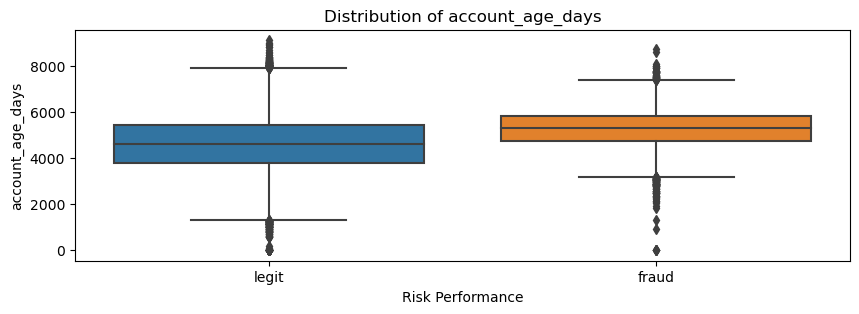

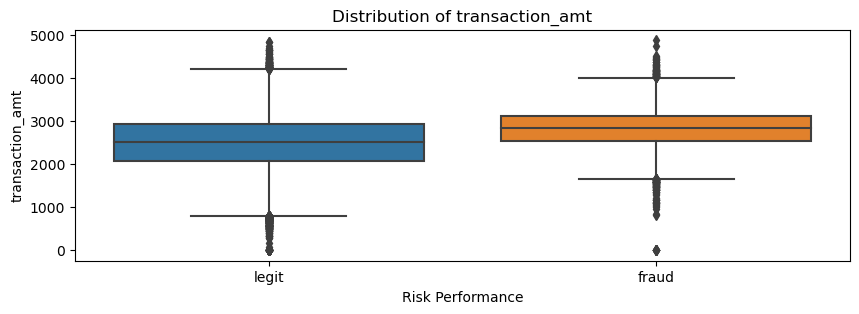

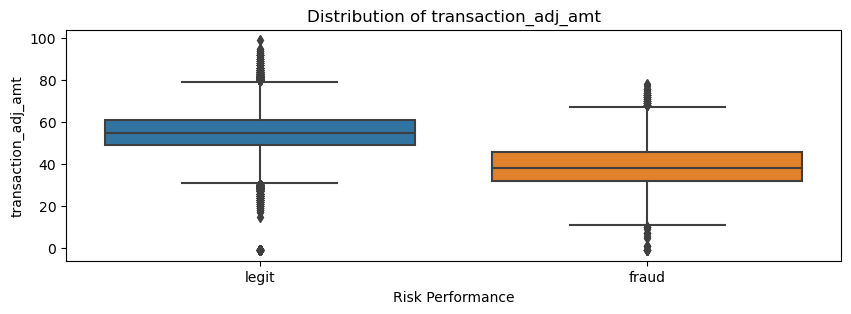

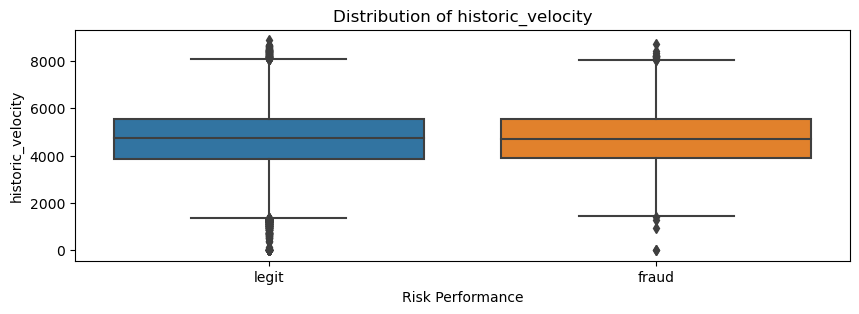

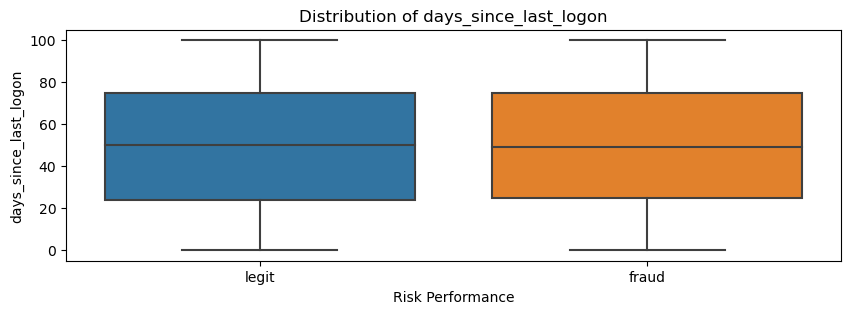

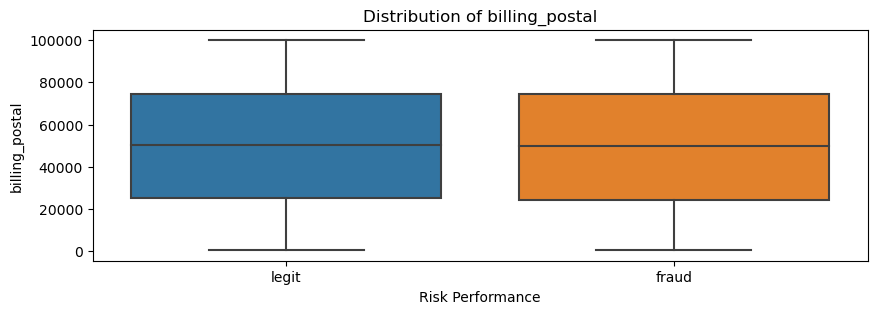

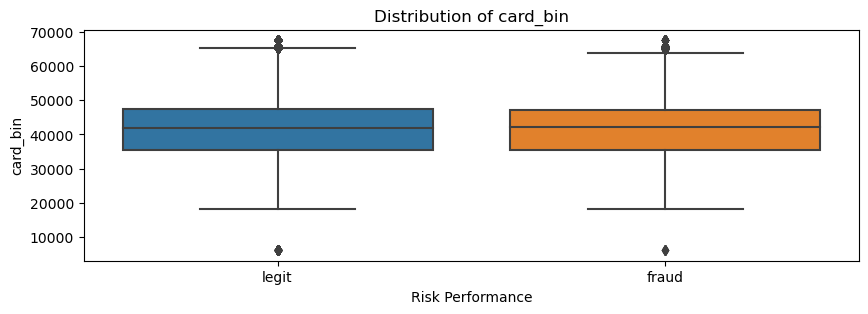

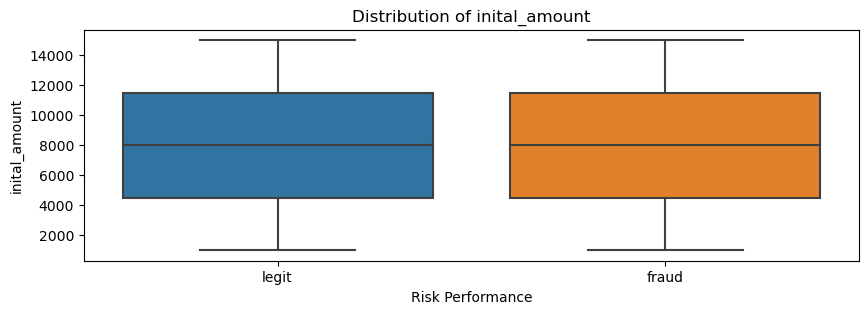

In [54]:
numeric_features = dfp.query('feature_type == "NUMERIC"')['feature_name'].to_list()
for num_col in numeric_features:
  plt.figure(figsize=(10, 3))
  sns.boxplot(x='EVENT_LABEL', y=num_col, data=df_train)
  plt.title(f'Distribution of {num_col}')
  plt.xlabel('Risk Performance')
  plt.ylabel(num_col)
  #plt.show()

In [45]:
df_train['event_label'].value_counts(normalize=True)

legit   0.94572
fraud   0.05428
Name: EVENT_LABEL, dtype: float64

## Data Preparation:

### Columns in dataset

In [10]:
df_train.columns

Index(['event_id', 'account_age_days', 'transaction_amt',
       'transaction_adj_amt', 'historic_velocity', 'ip_address', 'user_agent',
       'email_domain', 'phone_number', 'billing_city', 'billing_postal',
       'billing_state', 'card_bin', 'currency', 'cvv', 'signature_image',
       'transaction_type', 'transaction_env', 'event_timestamp',
       'applicant_name', 'billing_address', 'merchant_id', 'locale',
       'tranaction_initiate', 'days_since_last_logon', 'inital_amount',
       'event_label'],
      dtype='object')

In [11]:
df_holdout.columns

Index(['EVENT_ID', 'account_age_days', 'transaction_amt',
       'transaction_adj_amt', 'historic_velocity', 'ip_address', 'user_agent',
       'email_domain', 'phone_number', 'billing_city', 'billing_postal',
       'billing_state', 'card_bin', 'currency', 'cvv', 'signature_image',
       'transaction_type', 'transaction_env', 'EVENT_TIMESTAMP',
       'applicant_name', 'billing_address', 'merchant_id', 'locale',
       'tranaction_initiate', 'days_since_last_logon', 'inital_amount'],
      dtype='object')

### Identify Cat./Num Columns

In [82]:
categorical_cols = ['tranaction_initiate']
numerical_cols = ["account_age_days",	"transaction_amt",	"transaction_adj_amt",	"historic_velocity"]
feature_names = categorical_cols + numerical_cols
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

### Define Target Variable

In [55]:
# Define the target variable
y = df_train['EVENT_LABEL'].map({'legit': 0, 'fraud': 1})  # Convert to binary
X = df_train.drop('EVENT_LABEL', axis=1)

### Split Data into Train/Test Set

In [61]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=0)


In [63]:
X_train.head

<bound method NDFrame.head of        tranaction_initiate  account_age_days  transaction_amt  \
71132                    E        5906.00000       2875.00000   
7492                     U        3175.00000       1712.00000   
91459                    S        4349.00000       3780.00000   
5289                     Y        5914.00000       1653.00000   
120014                   T        2882.00000       2259.00000   
...                    ...               ...              ...   
45891                    M        5904.00000       3050.00000   
117952                   S        4891.00000       2865.00000   
42613                    I        3704.00000       1963.00000   
43567                    S        7133.00000       2628.00000   
68268                    E        5895.00000       3077.00000   

        transaction_adj_amt  historic_velocity  
71132              56.00000         4427.00000  
7492               59.00000         2474.00000  
91459              31.00000         5333.0

### Split Features

In [65]:
# 1. Split features into categorical and numeric
target = 'riskperformance_target'

numeric_features =  dfp.query('feature_type == "NUMERIC"')['feature_name'].to_list()
print(numeric_features)
categorical_features = numeric_features = dfp.query('feature_type == "CATEGORICAL"')['feature_name'].to_list()
print(categorical_features)

['account_age_days', 'transaction_amt', 'transaction_adj_amt', 'historic_velocity', 'days_since_last_logon', 'billing_postal', 'card_bin', 'inital_amount']
[]


## Model 1 - Logistic Reg:

#### LogReg Pipeline/Train

In [80]:
# Define the Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=0, max_iter=300))])

# Train the Logistic Regression model
lr_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['account_age_days',
                                                   'transaction_amt',
                                                   'transaction_adj_amt',
                                                   'historic_velocity']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tranaction_initiate'])])),
                ('classifier',
                 LogisticRegression(max_iter=300, random_state=0))])

#### Create Model Predictions and Accuracy

In [81]:
# Predict and evaluate the model
lr_predictions = lr_pipeline.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")

Logistic Regression Accuracy: 0.9566


#### Feature Importance

In [ ]:
feature_names = preprocessor.get_feature_names_out()
feature_importance = lr_pipeline.named_steps['classifier'].coef_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance[0]})
feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

In [ ]:
# Logistic Regression coefficients as feature importance
lr_coefficients = lr_pipeline.named_steps['classifier'].coef_[0]

# Aligning feature names and coefficients
lr_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_coefficients})
lr_feature_importance_df = lr_feature_importance_df.sort_values(by='Coefficient', ascending=False)
lr_feature_importance_df.head(10)


## Model 2 - RandomForest:

#### RF Pipeline/Train

In [66]:
# Define the Random Forest pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=50, n_jobs = -1, random_state=0))])

# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
rf_predictions = rf_pipeline.predict(X_test)
rf_predictions_proba = rf_pipeline.predict_proba(X_test)[:,1]
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")

Random Forest Accuracy: 0.9599


#### Create Model Predictions and Accuracy

In [77]:
# Predict and evaluate the model
rf_predictions = rf_pipeline.predict(X_test)
rf_predictions_proba = rf_pipeline.predict_proba(X_test)[:,1]
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")

Random Forest Accuracy: 0.9599


## Model 3 - (GBM):